In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `~/git/gregfa/bigriver/BigRiverQTL.jl`


In [4]:
Pkg.instantiate()

    Updating registry at `~/.julia/registries/General.toml`
   Installed ConstructionBase ─── v1.5.6
   Installed TranscodingStreams ─ v0.11.1
   Installed ArrayInterface ───── v7.14.0
   Installed QuadGK ───────────── v2.10.1
    Updating `~/git/gregfa/bigriver/BigRiverQTL.jl/Project.toml`
  [042156b7] + BigRiverQTLPlots v0.2.2
  [b8d15608] + BulkLMM v1.2.0
  [336ed68f] + CSV v0.10.14
  [324d7699] + CategoricalArrays v0.10.8
  [a93c6f00] + DataFrames v1.6.1
  [682c06a0] + JSON v0.21.4
  [2913bbd2] + StatsBase v0.34.3
  [10745b16] ~ Statistics ⇒ v1.10.0
    Updating `~/git/gregfa/bigriver/BigRiverQTL.jl/Manifest.toml`
  [79e6a3ab] + Adapt v4.0.4
  [66dad0bd] + AliasTables v1.1.3
  [4fba245c] + ArrayInterface v7.14.0
  [042156b7] + BigRiverQTLPlots v0.2.2
  [b8d15608] + BulkLMM v1.2.0
  [336ed68f] + CSV v0.10.14
  [49dc2e85] + Calculus v0.5.1
  [324d7699] + CategoricalArrays v0.10.8
  [944b1d66] + CodecZlib v0.7.5
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v4.15.0


In [3]:
using Revise

In [5]:
using BigRiverQTLPlots
using Random, Statistics
using Plots
using Helium
using BigRiverQTL
using CSV
using DataFrames
using BulkLMM

[ Info: Precompiling BigRiverQTLPlots [042156b7-ffc6-4e52-80f3-70a9c31dd28f]
[ Info: Precompiling ParsersExt [f526588d-e68b-5dc5-a62e-ff9f36e48b1a]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling BigRiverQTL [8f8ec94a-26d1-428c-aa0e-4e66223094bc]
[ Info: Precompiling SpecialFunctionsExt [997ecda8-951a-5f50-90ea-61382e97704b]
[ Info: Precompiling CategoricalArraysRecipesBaseExt [b7a5aa15-52bc-53b2-90b5-730883a6b80e]


In [6]:
##############
# BXD spleen #
##############

########
# Data #
########
data_dir = joinpath(@__DIR__, "../data/BXD/");
file = joinpath(data_dir, "bxd.json");

In [7]:
# Transforming data to a optimised and accessible data type
data = get_geneticstudydata(file);

In [35]:
gInfo=data.gmap;
pInfo=data.phenocov;
pheno=data.pheno;
pheno=data.pheno.val;
geno=reduce(hcat, data.geno.val);
geno_processed=convert(Array{Float64}, geno);

In [31]:
size(geno)

(198, 7320)

In [32]:
#################
# Preprocessing #
#################
traitID = 1112;
pheno_y = pheno[:, traitID];
pheno_y2=ones(length(pheno_y));
idx_nothing = findall(x->x!=nothing,pheno_y)
pheno_y2[idx_nothing]=pheno_y[idx_nothing];

In [36]:
###########
# Kinship #
###########
kinship = kinship_gs(geno_processed,.99);

In [37]:
########
# Scan #
########

single_results_perms = scan(
	pheno_y2,
	geno_processed,
	kinship;
	permutation_test = true,
	nperms = 1000,
);

In [38]:
size(geno_processed)

(198, 7320)

In [50]:
########
# Data #
########
bulklmmdir = dirname(pathof(BulkLMM));

gmap_file = joinpath(bulklmmdir, "..", "data", "bxdData", "gmap.csv");
gInfo2 = BulkLMM.CSV.read(gmap_file, BulkLMM.DataFrames.DataFrame);


In [44]:
gInfo2;

In [21]:
function gmap2df(gmap::Gmap)
    # Locus = reduce(vcat,gmap.marker_name);
    # Mb= reduce(vcat,gmap.pos);
    start=0
    Chr =repeat(["0"],sum(length.(gmap.marker_name)))
    
    # Pos =repeat(["Missing"],sum(length.(gmap.marker_name)))
    
    for i in eachindex(gmap.chr)
        l_i=length(gmap.marker_name[i])
        Chr[start+1:l_i+start] .= gmap.chr[i]
        start=start+l_i
    end
    df=DataFrame(
        Locus = reduce(vcat,gmap.marker_name),
        Chr = Chr,
        Pos= reduce(vcat,gmap.pos)
    )
        # Cm = repeat(["Missing"],sum(length.(gmap.marker_name)))
    return df

end

gmap2df (generic function with 1 method)

In [18]:
gInfo.chr

20-element Vector{String}:
 "1"
 "2"
 "3"
 "4"
 "5"
 "6"
 "7"
 "8"
 "9"
 "10"
 "11"
 "12"
 "13"
 "14"
 "15"
 "16"
 "17"
 "18"
 "19"
 "X"

In [19]:
# Locus=reduce(vcat,gmap.marker_name);
# Mb=reduce(vcat,gmap.pos);
# start=0
# Chr=repeat(["0"],sum(length.(gmap.marker_name)))
# Cm=repeat(["Missing"],sum(length.(gmap.marker_name)))
# for i in  eachindex(gmap.chr)
#     l_i=length(gmap.marker_name[i])
#     Chr[start+1:l_i+start] .= gmap.chr[i]
#     start=start+l_i
# end


In [39]:
gmap2df(gInfo);

In [52]:
function gmap2df(gmap::Gmap)
    Locus=reduce(vcat,gmap.marker_name);
    Mb=reduce(vcat,gmap.pos);
    start=0
    Chr=repeat(["0"],sum(length.(gmap.marker_name)))
    Cm=repeat([Missing],sum(length.(gmap.marker_name)))
    for i in  eachindex(gmap.chr)
        l_i=length(gmap.marker_name[i])
        Chr[start+1:l_i+start] .= gmap.chr[i]
        start=start+l_i
    end
    df=DataFrame(Locus=Locus,Chr=Chr,Mb=Mb,cM=Cm)
    return df

end

gmap2df (generic function with 1 method)

In [40]:
gInfo3=gmap2df(gInfo)

Row,Locus,Chr,Pos
,String,String,Float64
1,rs31443144,1,1.499
2,rs6269442,1,1.499
3,rs32285189,1,1.62623
4,rs258367496,1,1.62623
5,rs32430919,1,1.75345
6,rs36251697,1,1.88068
7,rs30658298,1,2.00791
8,rs51852623,1,2.00791
9,rs31879829,1,2.13513


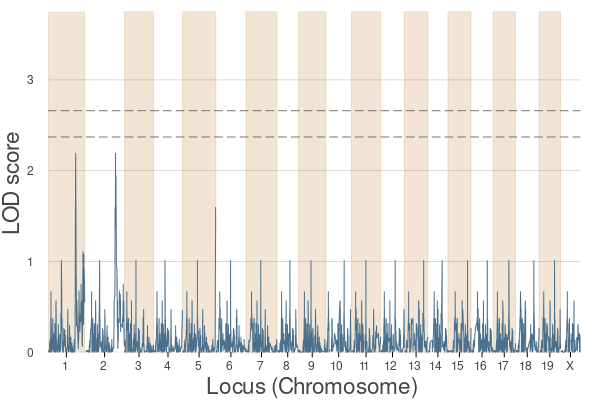

In [43]:
########
# Plot #
########

plot_QTL(single_results_perms, gInfo3, mbColname = "Pos")

